# Skeleton of Assignment 4:
    test if the distribution of 
    
    1) trip duration of bikers that ride during the day vs night
    
    2) age of bikers for trips originating in Manhattan and in Brooklyn (extra credit)
    
    are different. Use 3 tests: KS, Pearson's, Spearman's. 
    
    Use the scipy.stats functions scipy.stats.ks_2samp, scipy.stats.pearsonr, scipy.stats.spearmanr. 
    
    For the KS do the test with the entire dataset and with a subset 200 times smaller
    
    Choose a single significant threshold for the whole exercise. 
    
    For each test phrase the Null Hypothesis in words.
    
    Describe the return of the scipy function you use in each case.
    
    State the result in terms of rejection of the Null.

In [164]:
# my usual imports and setups
import pylab as pl
import pandas as pd
import numpy as np
import scipy.stats
from numpy import random

%pylab inline

import os
#this makes my plots pretty! but it is totally not mandatory to do it
import json
#s = json.load( open(os.getenv ('PUI2016')+"/fbb_matplotlibrc.json") )
#pl.rcParams.update(s)



Populating the interactive namespace from numpy and matplotlib


# Read in data
I am reading in data from January 2015 with the function that I created getCitiBikeCSV. You are requested to use 2 months at least. It would be a good idea to use data from a colder and a warmer months, since there are more riders in the warm weather and ridership patterns may change with weather, temperature, etc. You should use data from multiple months, joining multiple datasets (thus addressing some systematic errors as well)

In [165]:
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")
    else:
        print ("file in place, you can continue")

In [166]:
datestring1 = '201601'
getCitiBikeCSV(datestring1)

file in place, you can continue


In [167]:
datestring2 = '201608'
getCitiBikeCSV(datestring2)

file in place, you can continue


In [168]:
df1 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring1 + '-citibike-tripdata.csv')
df2 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring2 + '-citibike-tripdata.csv')
frames = [df1, df2]
df = pd.concat(frames,ignore_index=True)
df.head(5)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,923,1/1/2016 00:00:41,1/1/2016 00:16:04,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22285,Subscriber,1958.0,1
1,379,1/1/2016 00:00:45,1/1/2016 00:07:04,476,E 31 St & 3 Ave,40.743943,-73.979661,498,Broadway & W 32 St,40.748549,-73.988084,17827,Subscriber,1969.0,1
2,589,1/1/2016 00:00:48,1/1/2016 00:10:37,489,10 Ave & W 28 St,40.750664,-74.001768,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,21997,Subscriber,1982.0,2
3,889,1/1/2016 00:01:06,1/1/2016 00:15:56,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22794,Subscriber,1961.0,2
4,1480,1/1/2016 00:01:12,1/1/2016 00:25:52,2006,Central Park S & 6 Ave,40.765909,-73.976342,2006,Central Park S & 6 Ave,40.765909,-73.976342,14562,Subscriber,1952.0,1


In [169]:
df['hour'] = pd.to_datetime(df['starttime'],format="%m/%d/%Y %H:%M:%S").dt.hour

In [170]:
df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'hour'],
      dtype='object')

# SPLIT BY CATEGORY

as an example I am splitting data by gender and looking at age or riders:

**H0: there is no statistical difference in the age distribution of male and female riders**
$$ \alpha = 0.05 $$

extracting the age happens in the cell below

In [171]:
#df is the dataframe where the content of the csv file is stored
df['durD'] = df['tripduration'][(df['hour'] >= 6) & (df['hour'] < 18)]
df['durN'] = df['tripduration'][((df['hour'] >= 18) & (df['hour'] <= 23)) |((df['hour'] >= 0) & (df['hour'] < 6))]

In [172]:
#dropping some data I no longer need

df.drop(['starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid',
       'birth year', 'gender','usertype','hour','tripduration'], axis=1,inplace=True)
df.head()

,durD,durN
0,NaN,923.0
1,NaN,379.0
2,NaN,589.0
3,NaN,889.0
4,NaN,1480.0


In [173]:
#your df should look something like this
# look at these data carefully... you may see someinteresting values!
df.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,durD,durN
count,1.429848e+06,6.372930e+05
mean,9.424658e+02,9.587550e+02
std,8.854263e+03,1.063155e+04
min,6.100000e+01,6.100000e+01
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,3.565469e+06,3.966943e+06


In [174]:
# dropping NaN values
df['durD'].dropna(inplace= True)
df['durN'].dropna(inplace= True)

lets split age in 10 year bins. the dataset is very large, so i could be split in smaller bins, but I will chose 10 years in the interest of time. 
the bin size choice should be a balance between properly sample the age space, have enough counts in each bin that the statistical noise is not significant (remember that is > sqrt(N)!) and the computational requirement to computatinal facilities ratio. 

the next several steps are needed if you want to code up the KS test from scratch. that is for extra credit, so if you do not want to do it you may not need to plot split the distribution in bins and create the cumulative HOWEVER it is a great idea to do it anyways to explore your data viaually! remember Ascombe's quartet!!

Text(0,0.5,'Counts')

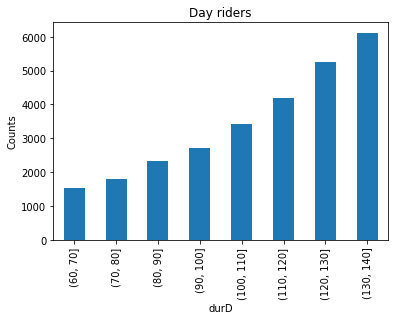

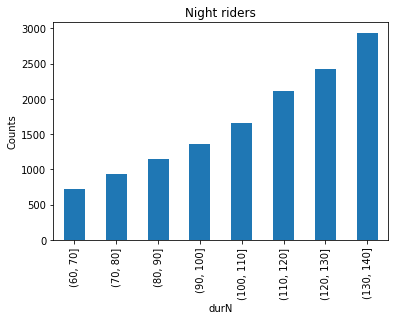

In [175]:
# plotting histogramswith pandas is a bitdifferent than with pylab
# this is a VERY USEFUL syntaxfor you to knonw!
bins = np.arange(60, 150, 10)
axD = df.durD.groupby(pd.cut(df.durD, bins)).agg([count_nonzero]).plot(kind='bar', 
                                                                   legend=False)
axD.set_title("Day riders")
axD.set_ylabel("Counts")


axN = df.durN.groupby(pd.cut(df.durN, bins)).agg([count_nonzero]).plot(kind='bar',
                                                                legend=False)
axN.set_title("Night riders")
axN.set_ylabel("Counts")


**Figure 1: histogrammed distribution of trip duration by day/night ** Shown the distributions trip duration of night rides and day rides are only slightly different, which may suggest that there is no statistical difference in the distribution of these two samples.

this is how the cumulative distributions look like.  Notice that i am normalizing them! if i want to reat an observed distribution like a probablility distribution i have to normalize it

            count_nonzero
durD                     
(60, 70]         0.001724
(70, 80]         0.002785
(80, 90]         0.003421
(90, 100]        0.005878
(100, 110]       0.005707
(110, 120]       0.011649
(120, 130]       0.002280
(130, 140]       0.000000


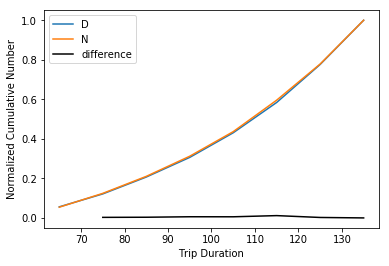

In [176]:
#print df.ageS, df.ageS.cumsum()

csD=df.durD.groupby(pd.cut(df.durD, bins)).agg([count_nonzero]).cumsum()

csN=df.durN.groupby(pd.cut(df.durN, bins)).agg([count_nonzero]).cumsum()

print (np.abs(csD / csD.max()-csN / csN.max()))

pl.plot(bins[:-1] + 5, csD / csD.max(), label = "D")
pl.plot(bins[:-1] + 5, csN / csN.max(), label = "N")
pl.plot(bins[:-1] + 5, np.sqrt(csN / csN.max() - csD / csD.max())**2, 'k-',
        label = "difference")
pl.xlabel("Trip Duration")
pl.ylabel("Normalized Cumulative Number")
pl.legend()

** Figure 2: the cumulative distribution of trip duration by Day/Night** Shown the cumulative distribution of trip durations of day rides and night rides are nearly the same, which suggesting there is no statistical difference in the distribution of these two samples.

# KS tests to compare 2 samples

http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ks_2samp.html

the KS test in scipy returns the p-value BUT make sure you understand what the NULL is! read the documentation carefully! what is the null hypothesis that you can/cannot reject?

Null Hypothesis: The sample of drip duration of day rides and the sample of drip duration of night rides were drawn from the same continuous distribution

Alternative Hypothesis: The sample of drip duration of day rides and the sample of drip duration of night rides were not drawn from the same continuous distribution

Significant Level: $\alpha$ = 0.05

In [177]:
ks = scipy.stats.ks_2samp(df.durD, df.durN)
print (ks)

Ks_2sampResult(statistic=0.0046493986901968709, pvalue=1.0499071857099388e-08)


In [178]:
score = ((len(df.durD) + len(df.durN))/(len(df.durD) * len(df.durN)))**0.5 * 1.36
print (score)

0.0020483749145304517


**KS Test**

The low k statistics, which is near 0, suggests that the difference between two 2 samples are really small, and the 2 samples are hightly likely to be drawn from the same distribution. 

However, because the p value, which equals 0, is also really small, we have to reject the null hypothesis that the distributions of the two samples are the same.

Also based on calculation, because 0.0046 > 0.002 ($D_KS(n1,n2) > c(\alpha) \sqrt{\frac{(n1 + n2)}{n1n2}}$), the null hypothesis is rejected

The scipy.stats KS test already tells me the significance and the p-value. 

The next few cells are here just to show you how you would obtain the same result by hand, but they are **not required**. 

Remember: the Null hypothesis is rejected if 

$D_KS(n1,n2) > c(\alpha) \sqrt{\frac{(n1 + n2)}{n1n2}}$

(see class notes) where $c(\alpha$) is the inverse of the KS distribution, and you do not have to know how to get that cause there are tables that list critical values!! 

http://www.real-statistics.com/tests-normality-and-symmetry/statistical-tests-normality-symmetry/kolmogorov-smirnov-test/kolmogorov-distribution/

But also this result depends in your choice of binning through, and thustheresultyou get by hand may not be exactly the same as the one the KS returns. Either way: this is how you would calculate the KS statistics by hand.

Null Hypothesis: The reduced sample of drip duration of day rides and the reduced sample of drip duration of night rides were drawn from the same continuous distribution

Alternative Hypothesis: The reduced sample of drip duration of day rides and the reduced sample of drip duration of night rides were not drawn from the same continuous distribution

Significant Level:  αα  = 0.05



In [183]:
#ks = scipy.stats.ks_2samp(df.durD[0:200], df.durN[0:200])
random.seed(100)
k1 = np.random.choice(df.durD, 200,replace=False)
k2 = np.random.choice(df.durN, 200,replace=False)
ks = scipy.stats.ks_2samp(k1, k2)

print (ks)

Ks_2sampResult(statistic=0.094999999999999973, pvalue=0.31244778531218792)


In [184]:
score = (((200 +200)/(200*200)))**0.5 * 1.36

print (score)

0.136


The k statistics of 0.095 suggests that distribution of the 2 reduced samples are slightly different. 

The p value, which equals 0.312, is larger than 0.05, so we failed to reject the null hypothesis that the distributions of the two samples are the same. 

Also based on calculation, because 0.095 < 0.136 ( $D_KS(n1,n2) > c(\alpha) \sqrt{\frac{(n1 + n2)}{n1n2}}$), the null hypothesis is not rejected

P value becomes unreliable when the sample size is too small

# Now retest using a test for correlation. 

That will answer a slightly different question though - formulate the NULL appropriately. The tests for correlations (generally) requires the variable to be paired, so that I can tell if x changes does y change similarly. But the datasets are of different size! You will need to reduce them to the same size. You can do that by subsampling of the data: take only 1 ride every of 200, which you can achieve "slicing and broadcasting" the array or using one of the python function (built in python numpy.random.choice() functions for example: Docstring:
choice(a, size=None, replace=True, p=None)

Generates a random sample from a given 1-D array

        .. versionadded:: 1.7.0

Parameters
...

But make sure you understand how to use it! there is an option "replace" which you should think about.

# Pearson's  test for correlation

** notice that the Pearson's is a pairwise test: the samples need to be **
 a. the same size
 b. sorted! (how??)
    
http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr



Null Hypothesis: There is no statistically significant relationship between "durD" (Trip Duration of Day Trips) and "durN" (Trip Duration of Night Trips)

Alternative Hypothesis: There is statistically significant relationship between "durD" (Trip Duration of Day Trips) and "durN" (Trip Duration of Night Trips)

Significant Level: $\alpha$ = 0.05

In [185]:
# your code here!
# wrangle the data as needed
# please perform the Pearson's test 
# and tell me what you find in terms of NULL hypothesis
random.seed(999)
p1 = np.random.choice(df.durD, 5000,replace=False)
p2 = np.random.choice(df.durN, 5000,replace=False)
p1 = np.sort(p1)
p2 = np.sort(p2)


scipy.stats.pearsonr(p1, p2)

(0.76255870037730011, 0.0)

The correlation of 0.76 suggests there's a strong positive relationship between the two variables.

Because p value < 0.05, we have to reject the null hypothesis, and to conclude that there is statistically significant relationship between "durD" (Trip Duration of Day Trips) and "durN". 

# Spearman's  test for correlation

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr

Null Hypothesis: There is no monotonic correlation between "durD" (Trip Duration of Day Trips) and "durN" (Trip Duration of Night Trips)

Alternative Hypothesis: There is monotonic correlation between "durD" (Trip Duration of Day Trips) and "durN" (Trip Duration of Night Trips)

Significant Level: $\alpha$ = 0.05

In [186]:
# your code here!
# wrangle the data as needed
# please perform the Spearman's test and tell me what you find in terms of NULL hypothesis
random.seed(999)
s1 = np.random.choice(df.durD, 8000,replace=False)
s2 = np.random.choice(df.durN, 8000,replace=False)
scipy.stats.spearmanr(s1,s2)

SpearmanrResult(correlation=-0.0011962186443630091, pvalue=0.91480772807890087)

The correlation of  -0.00012 suggests that there is no monotonic correlation between the two variables.

Because p value (0.915) > 0.05, we failed to reject the null hypothesis, and to conclude that There is no monotonic correlation between "durD" (Trip Duration of Day Trips) and "durN" (Trip Duration of Night Trips).
